<a href="https://colab.research.google.com/github/thesushpatil/DeepFake_Video_Detection/blob/master/Deepfake_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Step 1: Setup and Imports
# ==============================================================================
# We'll import all the modules we need for data processing, model building,
# and evaluation. All of these are pre-installed in Google Colab.
# ==============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [18]:
# @title Step 2: Configuration and Mounting Google Drive
# ==============================================================================
# This block contains all the key parameters for our experiment.
# It also mounts your Google Drive to give Colab access to your dataset.
# ❗ IMPORTANT ❗ -> You must update 'DATASET_BASE_PATH' to your folder path.
# ==============================================================================

# Mount Google Drive
drive.mount('/content/drive')

# Configuration
class Config:
    # ❗ UPDATE THIS PATH to your FaceForensics++ dataset in Google Drive
    DATASET_BASE_PATH = '/content/drive/MyDrive/Datasets/forensics++/'

    # We will use a subset of videos to make training faster for this example
    MAX_VIDEOS_PER_CLASS = 150 # Max videos from 'real' and 'fake' folders
    FRAMES_PER_VIDEO = 20      # Number of frames to extract from each video

    # Model and Training Parameters
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    EPOCHS = 15

# Please verify these paths match your folder structure.
REAL_VIDEOS_PATH = os.path.join(Config.DATASET_BASE_PATH, '/content/drive/MyDrive/Datasets/forensics++/FF++/real/')
FAKE_VIDEOS_PATH = os.path.join(Config.DATASET_BASE_PATH, '/content/drive/MyDrive/Datasets/forensics++/FF++/fake/')

# Define the output directory for frames
FRAME_OUTPUT_DIR = '/content/drive/MyDrive/Datasets/frames/'


print("Verified the Path of the folders")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Verified the Path of the folders


In [ ]:
# @title Step 3: Data Preparation - Frame Extraction
# ==============================================================================
# This cell scans the dataset folders and extracts a fixed number of frames
# from each video, saving them to a temporary directory in Colab.
# This process can take a few minutes.
# ==============================================================================

FRAME_OUTPUT_DIR = '/content/drive/MyDrive/Datasets/frames/'
if not os.path.exists(FRAME_OUTPUT_DIR):
    os.makedirs(os.path.join(FRAME_OUTPUT_DIR, 'real'))
    os.makedirs(os.path.join(FRAME_OUTPUT_DIR, 'fake'))

def extract_frames(video_path, output_folder, max_frames):
    """Extracts a fixed number of frames from a single video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < max_frames:
        return # Skip videos that are too short

    frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)
    video_filename = os.path.splitext(os.path.basename(video_path))[0]

    count = 0
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame_filename = f"{video_filename}_frame_{count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_filename), frame)
            count += 1
    cap.release()

# Process Real Videos
print("Extracting frames from REAL videos...")
real_videos = [os.path.join(REAL_VIDEOS_PATH, f) for f in os.listdir(REAL_VIDEOS_PATH)][:Config.MAX_VIDEOS_PER_CLASS]
for video_file in real_videos:
    extract_frames(video_file, os.path.join(FRAME_OUTPUT_DIR, 'real'), Config.FRAMES_PER_VIDEO)

# Process Fake Videos
print("Extracting frames from FAKE videos...")
fake_videos = [os.path.join(FAKE_VIDEOS_PATH, f) for f in os.listdir(FAKE_VIDEOS_PATH)][:Config.MAX_VIDEOS_PER_CLASS]
for video_file in fake_videos:
    extract_frames(video_file, os.path.join(FRAME_OUTPUT_DIR, 'fake'), Config.FRAMES_PER_VIDEO)

print("Frame extraction complete.")

Extracting frames from REAL videos...
Extracting frames from FAKE videos...
Frame extraction complete.


In [7]:
# @title Step 3a: Face Detection and Cropping ✂️
# ==============================================================================
# This new cell processes every extracted frame. It detects the face in the
# frame, crops it out, and overwrites the original frame with the cropped version.
# This ensures our model only sees the face.
# ==============================================================================
import cv2
import os
from tqdm import tqdm # For a nice progress bar

# Configuration - Added from a previous cell to ensure FRAME_OUTPUT_DIR is defined
# Removed duplicate Config and FRAME_OUTPUT_DIR definition
# class Config:
#     # ❗ UPDATE THIS PATH to your FaceForensics++ dataset in Google Drive
#     DATASET_BASE_PATH = '/content/drive/MyDrive/Datasets/forensics++/'

#     # We will use a subset of videos to make training faster for this example
#     MAX_VIDEOS_PER_CLASS = 150 # Max videos from 'real' and 'fake' folders
#     FRAMES_PER_VIDEO = 20      # Number of frames to extract from each video

#     # Model and Training Parameters
#     IMAGE_SIZE = (224, 224)
#     BATCH_SIZE = 32
#     LEARNING_RATE = 0.001
#     EPOCHS = 15

# FRAME_OUTPUT_DIR = '/content/drive/MyDrive/Datasets/frames/'
if not os.path.exists(FRAME_OUTPUT_DIR):
    os.makedirs(os.path.join(FRAME_OUTPUT_DIR, 'real'))
    os.makedirs(os.path.join(FRAME_OUTPUT_DIR, 'fake'))


# Load OpenCV's Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face_from_frame(image_path):
    """Loads an image, detects the face, crops it, and saves it back using OpenCV."""
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        # Get the first detected face (most likely the primary subject)
        (x, y, w, h) = faces[0]

        # Add a small padding to the crop
        padding = 20
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(image.shape[1], x + w + padding)
        y2 = min(image.shape[0], y + h + padding)

        # Crop the face
        cropped_face = image[y1:y2, x1:x2]

        # Save the cropped face back to the same file path
        cv2.imwrite(image_path, cropped_face)
        # print(f"Cropped face saved to: {image_path}")
    # else:
        # print(f"No face detected in: {image_path}")


# Get a list of all frames to process
real_frames_to_process = [os.path.join(FRAME_OUTPUT_DIR, 'real', f) for f in os.listdir(os.path.join(FRAME_OUTPUT_DIR, 'real'))]
fake_frames_to_process = [os.path.join(FRAME_OUTPUT_DIR, 'fake', f) for f in os.listdir(os.path.join(FRAME_OUTPUT_DIR, 'fake'))]
all_frames_to_process = real_frames_to_process + fake_frames_to_process

# Run the cropping function on all frames with a progress bar
print("Cropping faces from all extracted frames using OpenCV...")
for frame_path in tqdm(all_frames_to_process, desc="Processing frames"):
    crop_face_from_frame(frame_path)

print("Face cropping complete.")

KeyboardInterrupt: 

In [24]:
# @title Step 4: Create TensorFlow Data Pipeline (Modified for Error Handling)
# ==============================================================================
# This cell builds an efficient tf.data.Dataset pipeline. We've modified it
# to handle potential errors during image loading and decoding.
# ==============================================================================

real_frame_paths = [os.path.join(FRAME_OUTPUT_DIR, 'real', f) for f in os.listdir(os.path.join(FRAME_OUTPUT_DIR, 'real'))]
fake_frame_paths = [os.path.join(FRAME_OUTPUT_DIR, 'fake', f) for f in os.listdir(os.path.join(FRAME_OUTPUT_DIR, 'fake'))]
all_frame_paths = real_frame_paths + fake_frame_paths
labels = [0] * len(real_frame_paths) + [1] * len(fake_frame_paths)

# Split data into training + test, and validation sets (80/20 split for validation)
X_train_temp, X_val, y_train_temp, y_val = train_test_split(all_frame_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Now split the remaining data (X_train_temp, y_train_temp) into training and test sets (e.g., 75/25 split)
X_train, X_test, y_train, y_test = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42, stratify=y_train_temp) # 0.25 of 0.8 is 0.2

print(f"Total samples: {len(all_frame_paths)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


def parse_function(filename, label):
    """Reads an image file, decodes it, and applies preprocessing, handling errors."""
    image_string = tf.io.read_file(filename)

    # Use tf.cond to handle empty or invalid image strings safely within the graph
    def process_valid_image():
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, Config.IMAGE_SIZE)
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        return image, label

    def handle_invalid_image():
        # Return a placeholder tensor for invalid images.
        # Use a shape and dtype consistent with the valid image processing path.
        # A label of -1 will be used to filter these out later.
        placeholder_image = tf.zeros(shape=(Config.IMAGE_SIZE[0], Config.IMAGE_SIZE[1], 3), dtype=tf.float32)
        placeholder_label = tf.constant(-1, dtype=tf.int32) # Use tf.int32 for labels consistency
        return placeholder_image, placeholder_label

    # Check if the image string is valid. Decode_jpeg will also raise an error on invalid data,
    # but checking length first can sometimes be faster for empty files.
    # A more robust check might involve a try-except within tf.py_function,
    # but tf.cond is generally preferred within tf.data.Dataset.map for performance.
    is_valid = tf.greater(tf.strings.length(image_string), 0)

    # Execute either process_valid_image or handle_invalid_image based on is_valid
    return tf.cond(is_valid, process_valid_image, handle_invalid_image)


def create_dataset(filepaths, labels):
    """Creates a tf.data.Dataset from filepaths and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    # Filter out invalid samples that were marked with label -1
    dataset = dataset.filter(lambda x, y: tf.not_equal(y, -1))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(Config.BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(X_train, y_train) # Add .repeat() here
val_ds = create_dataset(X_val, y_val)
# We don't create a test_ds pipeline in this cell, but you would typically do it here
# test_ds = create_dataset(X_test, y_test)

Total samples: 6000
Training samples: 3600
Validation samples: 1200
Test samples: 1200


In [25]:
# @title Step 5: Build the Model
# ==============================================================================
# Here we define the model architecture using the pre-trained EfficientNetB0
# as our base. This use of transfer learning is key to getting good results.
# ==============================================================================
#
def build_model():
    """Builds the deepfake detection model using EfficientNetB0."""
    # We now use the standard EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(Config.IMAGE_SIZE[0], Config.IMAGE_SIZE[1], 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification
    ])
    return model

model = build_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [23]:
# @title Step 6: Train the Model
# ==============================================================================
# This cell starts the training process. Callbacks are used to save the
# best model and to stop training early if performance stops improving.
# ==============================================================================

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True, monitor="val_accuracy"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True, monitor="val_loss"
)

# Custom callback to print epoch number and metrics
class PrintMetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}/{self.params['epochs']}")
        print(f"Loss: {logs.get('loss'):.4f} - Accuracy: {logs.get('accuracy'):.4f} - Precision: {logs.get('precision'):.4f} - Recall: {logs.get('recall'):.4f}")
        if 'val_loss' in logs:
             print(f"Val Loss: {logs.get('val_loss'):.4f} - Val Accuracy: {logs.get('val_accuracy'):.4f} - Val Precision: {logs.get('val_precision'):.4f} - Val Recall: {logs.get('val_recall'):.4f}")
        print("-" * 30)

print_metrics_cb = PrintMetricsCallback()


print("\nStarting model training...")
print(f"Number of Epochs: {Config.EPOCHS}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Image Size: {Config.IMAGE_SIZE}")
print("Training data: train_ds (created from extracted and processed frames)")

history = model.fit(
    train_ds,
    epochs=Config.EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, print_metrics_cb] # Add the custom callback
)
print("Model training complete.")


Starting model training...
Number of Epochs: 15
Batch Size: 32
Image Size: (224, 224)
Training data: train_ds (created from extracted and processed frames)
Epoch 1/15
     19/Unknown 6s 139ms/step - accuracy: 0.9522 - loss: 0.1137 - precision_4: 0.9262 - recall_4: 0.9784

KeyboardInterrupt: 

In [1]:
# @title Step 8: Fine-Tuning the Model (Optional Next Step)
# ==============================================================================
# Now we unfreeze the top layers of the base model and continue training
# with a very low learning rate to fine-tune the model for our specific task.
# ==============================================================================

# Unfreeze the base model
model.get_layer('efficientnetb0').trainable = True

# A common practice is to unfreeze the top layers. Let's start by unfreezing all of it,
# but using a tiny learning rate will prevent large, destructive updates.

# We must re-compile the model for these changes to take effect.
# It is crucial to use a very low learning rate.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

print("\nStarting model fine-tuning...")
# Continue training for a few more epochs
fine_tune_epochs = 5
total_epochs = Config.EPOCHS + fine_tune_epochs

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where the last training finished
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb] # You can re-use the same callbacks
)
print("Model fine-tuning complete.")

NameError: name 'model' is not defined

19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 613ms/step - accuracy: 0.5146 - loss: 0.6928 - precision: 0.0000e+00 - recall: 0.0000e+00

Validation Accuracy: 0.5000
Validation Precision: 0.0000
Validation Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


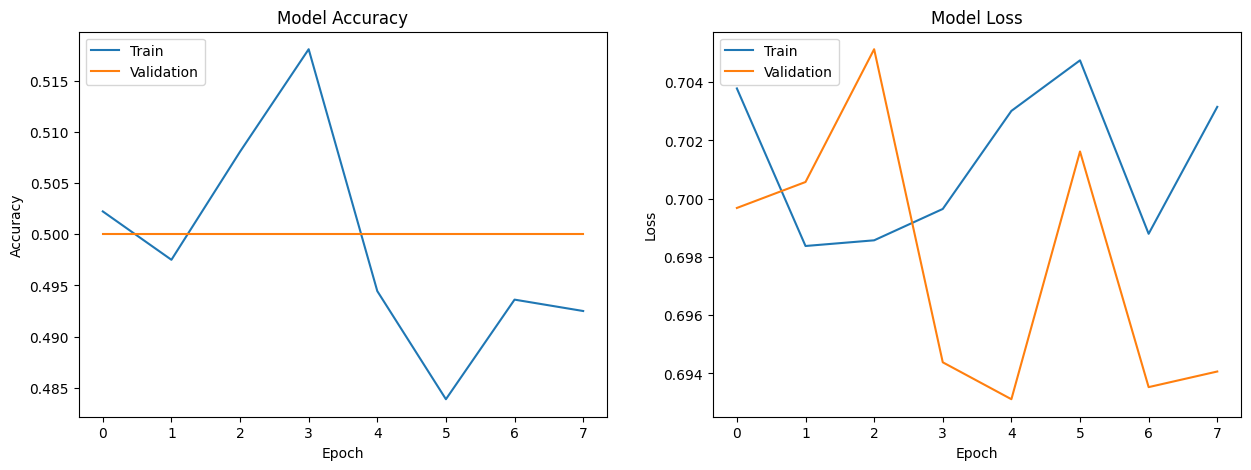

In [14]:
# @title Step 8: Evaluate the Model
# ==============================================================================
# Finally, we evaluate our trained model's performance on the validation set
# and visualize the training history to check for issues like overfitting.
# ==============================================================================

# best_model = keras.models.load_model("best_model.h5")

# val_loss, val_acc, val_prec, val_recall = best_model.evaluate(val_ds)
# print(f"\nValidation Accuracy: {val_acc:.4f}")
# print(f"Validation Precision: {val_prec:.4f}")
# print(f"Validation Recall: {val_recall:.4f}")

# def plot_history(history):
#     """Plots accuracy and loss curves for training and validation sets."""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#     # Plot training & validation accuracy values
#     ax1.plot(history.history['accuracy'])
#     ax1.plot(history.history['val_accuracy'])
#     ax1.set_title('Model Accuracy')
#     ax1.set_ylabel('Accuracy')
#     ax1.set_xlabel('Epoch')
#     ax1.legend(['Train', 'Validation'], loc='upper left')

#     # Plot training & validation loss values
#     ax2.plot(history.history['loss'])
#     ax2.plot(history.history['val_loss'])
#     ax2.set_title('Model Loss')
#     ax2.set_ylabel('Loss')
#     ax2.set_xlabel('Epoch')
#     ax2.legend(['Train', 'Validation'], loc='upper left')

#     plt.show()

# plot_history(history)